# Assignment 2
## 0813366 黃柏翔

# Data Preprocessing

In [217]:
######################
# data preprocessing #
######################

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.decomposition import PCA 
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# read and shuffle
origin_df = pd.read_csv("student-mat.csv",sep = ';')
origin_df = origin_df.sample(frac=1, random_state=42).reset_index(drop=True)

categorical_col = list(filter(lambda col: type(origin_df[col][0])== str, origin_df.columns))
numeric_col = list(filter(lambda col: type(origin_df[col][0])== np.int64, origin_df.columns))

# one-hot encoding
categorical_df = pd.get_dummies(origin_df.loc[:,categorical_col])

# drop lable and normalize
numeric_df = origin_df.loc[:,numeric_col].drop('G3',axis = 'columns')
#numeric_df = (numeric_df-numeric_df.min())/(numeric_df.max()-numeric_df.min())

all_x = categorical_df.join(numeric_df)
all_y = origin_df['G3']
y_plot = []
y_binary = []
y_5level = []

for num in  all_y:
    if num >= 10:
        y_binary.append('Pass')
        y_plot.append(1)
    else:
        y_binary.append('Fail')
        y_plot.append(0)
        
    if num < 10:
        y_5level.append('F')
    elif num < 12:
        y_5level.append('D')
    elif num < 14:
        y_5level.append('C')
    elif num < 16:
        y_5level.append('B')
    elif num <= 20:
        y_5level.append('A')


        
split = int(len(all_x.index)*7/10)
X_train = all_x[:split]
X_test = all_x[split:]
y_train_binary = y_binary[:split]
y_test_binary = y_binary[split:]
y_train_5level = y_5level[:split]
y_test_5level = y_5level[split:]
y_plot = y_plot[:split]
# pca ( only for numeric data )


pca = PCA(n_components='mle')
pca.fit(numeric_df[:split])#

#pca_numeric_df = pca.fit_transform(numeric_df)
#X_train_pca = categorical_df.iloc[:split].astype('float32').join(pd.DataFrame((pca.transform(numeric_df.iloc[:split,:])),columns=numeric_df.columns))
#X_test_pca  = (categorical_df.iloc[split:].astype('float32')).join(pd.DataFrame((pca.transform(numeric_df.iloc[split:]))))
#X_train_pca = pca_all_x[:int(len(pca_all_x)*7/10)]
#X_test_pca = pca_all_x[int(len(pca_all_x)*7/10):]

X_train_pca = np.hstack([categorical_df.values[:split].astype('float32'),pca.transform(numeric_df.iloc[:split,:])])
X_test_pca = np.hstack([categorical_df.values[split:].astype('float32'),pca.transform(numeric_df.iloc[split:,:])])




# BINARY

##  - Decision tree without PCA
sklearn的decision tree採用CART演算法
CART演算法在每次判斷過程，都是對觀察變數進行二分
且每次最佳劃分都是針對單個變數劃分，因此最後建構完成的是簡潔的二叉樹。

最後再經由剪枝(Pruning)，刪去多餘的雜訊，解決overfitting的問題

In [218]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clf_p = DecisionTreeClassifier(max_leaf_nodes = 4, random_state=0)
clf_p.fit(X_train, y_train_binary)
dt_y_predict_binary = clf_p.predict(X_test)

print('confusion matrix\n\n',confusion_matrix(y_test_binary,dt_y_predict_binary,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,dt_y_predict_binary,digits = 4))

confusion matrix

 [[30  7]
 [ 2 80]]
              precision    recall  f1-score   support

        Fail     0.9375    0.8108    0.8696        37
        Pass     0.9195    0.9756    0.9467        82

    accuracy                         0.9244       119
   macro avg     0.9285    0.8932    0.9082       119
weighted avg     0.9251    0.9244    0.9227       119



## - Decision tree with PCA


In [199]:
clf = DecisionTreeClassifier(max_leaf_nodes = 4, random_state=0)
clf.fit(X_train_pca, y_train_binary)
dt_y_predict_binary_pca = clf.predict(X_test_pca)


print('confusion matrix\n',confusion_matrix(y_test_binary,dt_y_predict_binary,labels =['Fail','Pass']))
print(classification_report(y_test_binary,dt_y_predict_binary_pca,digits = 4))

confusion matrix
 [[30  7]
 [ 2 80]]
              precision    recall  f1-score   support

        Fail     0.9091    0.5405    0.6780        37
        Pass     0.8247    0.9756    0.8939        82

    accuracy                         0.8403       119
   macro avg     0.8669    0.7581    0.7859       119
weighted avg     0.8510    0.8403    0.8267       119



## - Random forest without PCA

In [4]:
# RF


clf = RandomForestClassifier(n_estimators = 50, random_state=0)
clf.fit(X_train, y_train_binary)
rf_y_predict_binary = clf.predict(X_test)

print('confusion matrix for 50 trees\n\n',confusion_matrix(y_test_binary,rf_y_predict_binary,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,rf_y_predict_binary,digits = 4))
print('-'*80,'\n')

clf = RandomForestClassifier(n_estimators = 100, random_state=0)
clf.fit(X_train, y_train_binary)
rf_y_predict_binary = clf.predict(X_test)

print('confusion matrix for 100 trees\n\n',confusion_matrix(y_test_binary,rf_y_predict_binary,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,rf_y_predict_binary,digits = 4))
print('-'*80,'\n')

clf = RandomForestClassifier(n_estimators = 200, random_state=0)
clf.fit(X_train, y_train_binary)
rf_y_predict_binary = clf.predict(X_test)

print('confusion matrix for 200 trees\n\n',confusion_matrix(y_test_binary,rf_y_predict_binary,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,rf_y_predict_binary,digits = 4))
print('-'*80,'\n')

confusion matrix for 50 trees

 [[32  5]
 [ 6 76]]
              precision    recall  f1-score   support

        Fail     0.8421    0.8649    0.8533        37
        Pass     0.9383    0.9268    0.9325        82

    accuracy                         0.9076       119
   macro avg     0.8902    0.8958    0.8929       119
weighted avg     0.9084    0.9076    0.9079       119

-------------------------------------------------------------------------------- 

confusion matrix for 100 trees

 [[31  6]
 [ 6 76]]
              precision    recall  f1-score   support

        Fail     0.8378    0.8378    0.8378        37
        Pass     0.9268    0.9268    0.9268        82

    accuracy                         0.8992       119
   macro avg     0.8823    0.8823    0.8823       119
weighted avg     0.8992    0.8992    0.8992       119

-------------------------------------------------------------------------------- 

confusion matrix for 200 trees

 [[32  5]
 [ 5 77]]
              precision  

## - Random forest with PCA

In [200]:
clf = RandomForestClassifier(n_estimators = 50, random_state=0)
clf.fit(X_train_pca, y_train_binary)
rf_y_predict_binary_pca = clf.predict(X_test_pca)

print('confusion matrix for 50 trees\n',confusion_matrix(y_test_binary,rf_y_predict_binary_pca,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,rf_y_predict_binary_pca,digits = 4))

confusion matrix for 50 trees
 [[29  8]
 [ 5 77]]
              precision    recall  f1-score   support

        Fail     0.8529    0.7838    0.8169        37
        Pass     0.9059    0.9390    0.9222        82

    accuracy                         0.8908       119
   macro avg     0.8794    0.8614    0.8695       119
weighted avg     0.8894    0.8908    0.8894       119



## - KNN without PCA

In [88]:

neigh_p = KNeighborsClassifier(n_neighbors = 5)
neigh_p.fit(X_train.values, y_train_binary)
knn_y_predict_binary_p = neigh_p.predict(X_test.values)

print('confusion matrix\n\n',confusion_matrix(y_test_binary,knn_y_predict_binary_p,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,knn_y_predict_binary_p,digits = 4))
print('-'*80,'\n')

neigh = KNeighborsClassifier(n_neighbors = 10)
neigh.fit(X_train.values, y_train_binary)
knn_y_predict_binary = neigh.predict(X_test.values)

print('confusion matrix\n\n',confusion_matrix(y_test_binary,knn_y_predict_binary,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,knn_y_predict_binary,digits = 4))
print('-'*80,'\n')

neigh = KNeighborsClassifier(n_neighbors = 30)
neigh.fit(X_train.values, y_train_binary)
knn_y_predict_binary = neigh.predict(X_test.values)

print('confusion matrix\n\n',confusion_matrix(y_test_binary,knn_y_predict_binary,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,knn_y_predict_binary,digits = 4))
print('-'*80,'\n')

confusion matrix

 [[29  8]
 [ 9 73]]
              precision    recall  f1-score   support

        Fail     0.7632    0.7838    0.7733        37
        Pass     0.9012    0.8902    0.8957        82

    accuracy                         0.8571       119
   macro avg     0.8322    0.8370    0.8345       119
weighted avg     0.8583    0.8571    0.8577       119

-------------------------------------------------------------------------------- 

confusion matrix

 [[27 10]
 [ 7 75]]
              precision    recall  f1-score   support

        Fail     0.7941    0.7297    0.7606        37
        Pass     0.8824    0.9146    0.8982        82

    accuracy                         0.8571       119
   macro avg     0.8382    0.8222    0.8294       119
weighted avg     0.8549    0.8571    0.8554       119

-------------------------------------------------------------------------------- 

confusion matrix

 [[28  9]
 [ 5 77]]
              precision    recall  f1-score   support

        Fai

## - KNN with PCA

In [202]:
neigh = KNeighborsClassifier(n_neighbors = 30)
neigh.fit(X_train_pca, y_train_binary)
knn_y_predict_binary_pca = neigh.predict(X_test_pca)

print('confusion matrix\n',confusion_matrix(y_test_binary,knn_y_predict_binary_pca,labels = ['Fail','Pass']))
print(classification_report(y_test_binary,knn_y_predict_binary_pca,digits = 4))

confusion matrix
 [[27 10]
 [ 5 77]]
              precision    recall  f1-score   support

        Fail     0.8438    0.7297    0.7826        37
        Pass     0.8851    0.9390    0.9112        82

    accuracy                         0.8739       119
   macro avg     0.8644    0.8344    0.8469       119
weighted avg     0.8722    0.8739    0.8712       119



# 5-LEVEL

## - Decision tree without PCA

In [8]:
clf = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=0)
clf.fit(X_train, y_train_5level)
dt_y_predict_5level = clf.predict(X_test)


print('confusion matrix\n',confusion_matrix(y_test_5level,dt_y_predict_5level,labels = ['A','B','C','D','F']))
print(classification_report(y_test_5level,dt_y_predict_5level,digits = 4))

confusion matrix
 [[11  1  0  0  0]
 [ 1 18  4  0  0]
 [ 0  0 14  1  0]
 [ 0  0  1 25  6]
 [ 0  0  0  5 32]]
              precision    recall  f1-score   support

           A     0.9167    0.9167    0.9167        12
           B     0.9474    0.7826    0.8571        23
           C     0.7368    0.9333    0.8235        15
           D     0.8065    0.7812    0.7937        32
           F     0.8421    0.8649    0.8533        37

    accuracy                         0.8403       119
   macro avg     0.8499    0.8557    0.8489       119
weighted avg     0.8471    0.8403    0.8407       119



## - Decision tree with PCA

<< warning msg won't influence the result >>

In [203]:
clf = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=0)
clf.fit(X_train_pca, y_train_5level)
dt_y_predict_5level_pca = clf.predict(X_test_pca)

print('confusion matrix\n',confusion_matrix(y_test_5level,dt_y_predict_5level,labels = ['A','B','C','D','F']))
print(classification_report(y_test_5level,dt_y_predict_5level_pca,digits = 4))

confusion matrix
 [[11  1  0  0  0]
 [ 1 18  4  0  0]
 [ 0  0 14  1  0]
 [ 0  0  1 25  6]
 [ 0  0  0  5 32]]
              precision    recall  f1-score   support

           A     0.4400    0.9167    0.5946        12
           B     0.0000    0.0000    0.0000        23
           C     0.4545    0.6667    0.5405        15
           D     0.6000    0.3750    0.4615        32
           F     0.6731    0.9459    0.7865        37

    accuracy                         0.5714       119
   macro avg     0.4335    0.5809    0.4766       119
weighted avg     0.4723    0.5714    0.4968       119



c:\users\william\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\william\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\william\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

## - Random forest without PCA

In [10]:
clf = RandomForestClassifier(n_estimators = 50, random_state=0)
clf.fit(X_train, y_train_5level)
rf_y_predict_5level = clf.predict(X_test)

print('confusion matrix for 50 trees\n\n',confusion_matrix(y_test_5level,rf_y_predict_5level,labels = ['A','B','C','D','F']))
print(classification_report(y_test_5level,rf_y_predict_5level,digits = 4))
print('-'*80,'\n')

# clf = RandomForestClassifier(n_estimators = 100, random_state=0)
# clf.fit(X_train, y_train_5level)
# rf_y_predict_5level = clf.predict(X_test)

# print('confusion matrix for 100 trees\n\n',confusion_matrix(y_test_5level,rf_y_predict_5level,labels = ['A','B','C','D','F']))
# print(classification_report(y_test_5level,rf_y_predict_5level,digits = 4))
# print('-'*80,'\n')

# clf = RandomForestClassifier(n_estimators = 200, random_state=0)
# clf.fit(X_train, y_train_5level)
# rf_y_predict_5level = clf.predict(X_test)

# print('confusion matrix for 200 trees\n\n',confusion_matrix(y_test_5level,rf_y_predict_5level,labels = ['A','B','C','D','F']))
# print(classification_report(y_test_5level,rf_y_predict_5level,digits = 4))
# print('-'*80,'\n')

confusion matrix for 50 trees

 [[ 7  5  0  0  0]
 [ 2 15  5  1  0]
 [ 0  1  9  5  0]
 [ 0  0  4 22  6]
 [ 0  0  0  6 31]]
              precision    recall  f1-score   support

           A     0.7778    0.5833    0.6667        12
           B     0.7143    0.6522    0.6818        23
           C     0.5000    0.6000    0.5455        15
           D     0.6471    0.6875    0.6667        32
           F     0.8378    0.8378    0.8378        37

    accuracy                         0.7059       119
   macro avg     0.6954    0.6722    0.6797       119
weighted avg     0.7140    0.7059    0.7075       119

-------------------------------------------------------------------------------- 



## - Random forest with PCA

In [204]:
clf = RandomForestClassifier(n_estimators = 50, random_state=0)
clf.fit(X_train_pca, y_train_5level)
rf_y_predict_5level_pca = clf.predict(X_test_pca)

print('confusion matrix\n\n',confusion_matrix(y_test_5level,rf_y_predict_5level_pca,labels = ['A','B','C','D','F']))
print(classification_report(y_test_5level,rf_y_predict_5level_pca,digits = 4))

confusion matrix

 [[ 8  4  0  0  0]
 [ 2 15  4  1  1]
 [ 0  2  6  7  0]
 [ 0  0  6 17  9]
 [ 0  0  1  5 31]]
              precision    recall  f1-score   support

           A     0.8000    0.6667    0.7273        12
           B     0.7143    0.6522    0.6818        23
           C     0.3529    0.4000    0.3750        15
           D     0.5667    0.5312    0.5484        32
           F     0.7561    0.8378    0.7949        37

    accuracy                         0.6471       119
   macro avg     0.6380    0.6176    0.6255       119
weighted avg     0.6507    0.6471    0.6470       119



## - KNN without PCA

In [12]:
neigh = KNeighborsClassifier(n_neighbors = 30)
neigh.fit(X_train.values, y_train_5level)
knn_y_predict_5level = neigh.predict(X_test.values)

print('confusion matrix\n',confusion_matrix(y_test_5level,knn_y_predict_5level,labels = ['A','B','C','D','F']))
print(classification_report(y_test_5level,knn_y_predict_5level,digits = 4))

confusion matrix
 [[ 5  6  1  0  0]
 [ 0 17  4  2  0]
 [ 0  3  6  6  0]
 [ 0  0  3 20  9]
 [ 0  0  0 10 27]]
              precision    recall  f1-score   support

           A     1.0000    0.4167    0.5882        12
           B     0.6538    0.7391    0.6939        23
           C     0.4286    0.4000    0.4138        15
           D     0.5263    0.6250    0.5714        32
           F     0.7500    0.7297    0.7397        37

    accuracy                         0.6303       119
   macro avg     0.6717    0.5821    0.6014       119
weighted avg     0.6560    0.6303    0.6292       119



## - KNN with PCA

In [206]:
neigh = KNeighborsClassifier(n_neighbors = 30, weights = 'distance')
neigh.fit(X_train_pca, y_train_5level)
knn_y_predict_5level_pca = neigh.predict(X_test_pca)

print('confusion matrix\n\n',confusion_matrix(y_test_5level,knn_y_predict_5level_pca,labels = ['A','B','C','D','F']))
print(classification_report(y_test_5level,knn_y_predict_5level_pca,digits = 4))

confusion matrix

 [[ 6  5  1  0  0]
 [ 0 17  4  2  0]
 [ 0  3  6  6  0]
 [ 0  0  2 20 10]
 [ 0  0  0 10 27]]
              precision    recall  f1-score   support

           A     1.0000    0.5000    0.6667        12
           B     0.6800    0.7391    0.7083        23
           C     0.4615    0.4000    0.4286        15
           D     0.5263    0.6250    0.5714        32
           F     0.7297    0.7297    0.7297        37

    accuracy                         0.6387       119
   macro avg     0.6795    0.5988    0.6209       119
weighted avg     0.6589    0.6387    0.6387       119



# Validation

In [ ]:
##

# Result
## Binary
|   BINARY  |Decision tree without PCA|Decision tree with PCA|Random forest without PCA(50)|Random forest with PCA(50)|KNN without PCA(30)|KNN with PCA(30)
|-----------|:------:|:------:|:------:|:------:|:------:|:------:
|Accuracy|0.9244|0.8403|0.9076|0.8908|0.8824|0.8739
|Recall|0.8932|0.7581|0.8958|0.8614|0.8479|0.8344
|Precision|0.9285|0.8669|0.8902|0.8794|0.8719|0.8644

## RF with different #trees
數量多寡不太會影響結果 

|   BINARY  |Random forest without PCA(50)|Random forest without PCA(100)|Random forest without PCA(200)
|-----------|:------:|:------:|:------:
|Accuracy|0.9076|0.8992|0.9160
|Recall|0.8958|0.8823|0.9019
|Precision|0.8902|0.8823|0.9019

## KNN with different #neighbors
KNN 可能會因為n_neighbors不同，造成acc的差異  

|   BINARY  |KNN without PCA(5)|KNN without PCA(10)|KNN without PCA(30)
|-----------|:------:|:------:|:------:
|Accuracy|0.8571|0.8571|0.8824
|Recall|0.8370|0.8222|0.8479
|Precision|0.8322|0.8382|0.8719



##  5-level
|   5-level  |Decision tree without PCA|Decision tree with PCA|Random forest without PCA(50)|Random forest with PCA(50)|KNN without PCA(30)|KNN with PCA(30)
|-----------|:------:|:------:|:------:|:------:|:------:|:------:
|Accuracy|0.8403|0.5714|0.7059|0.6471|0.6303|0.6387
|Recall|0.8557|0.5809|0.6722|0.6176|0.5821|0.5988
|Precision|0.8499|0.4335|0.6954|0.6380|0.6717|0.6795



# Comparison & Conclusion
PCA的模式我選擇用'mle'讓他自動選擇要降到幾維  
只有對numeric feature做PCA，由15維降到11維
因為PCA是做線性轉換，有可能因為特徵的結構並沒有那麼線性
這樣降維反而可能導致資訊變少
所以PCA後的結果在這個dataset底下的表現是較差的

# Questions 

## Decision Tree
觀察最左邊 gini = 0.104 的橘色方塊  
第一層 G2 <= 9.5 -> True 往左  
第二層 G2 <= 8.5 -> True 往左  
此時可得到該樣本為Fail的結果

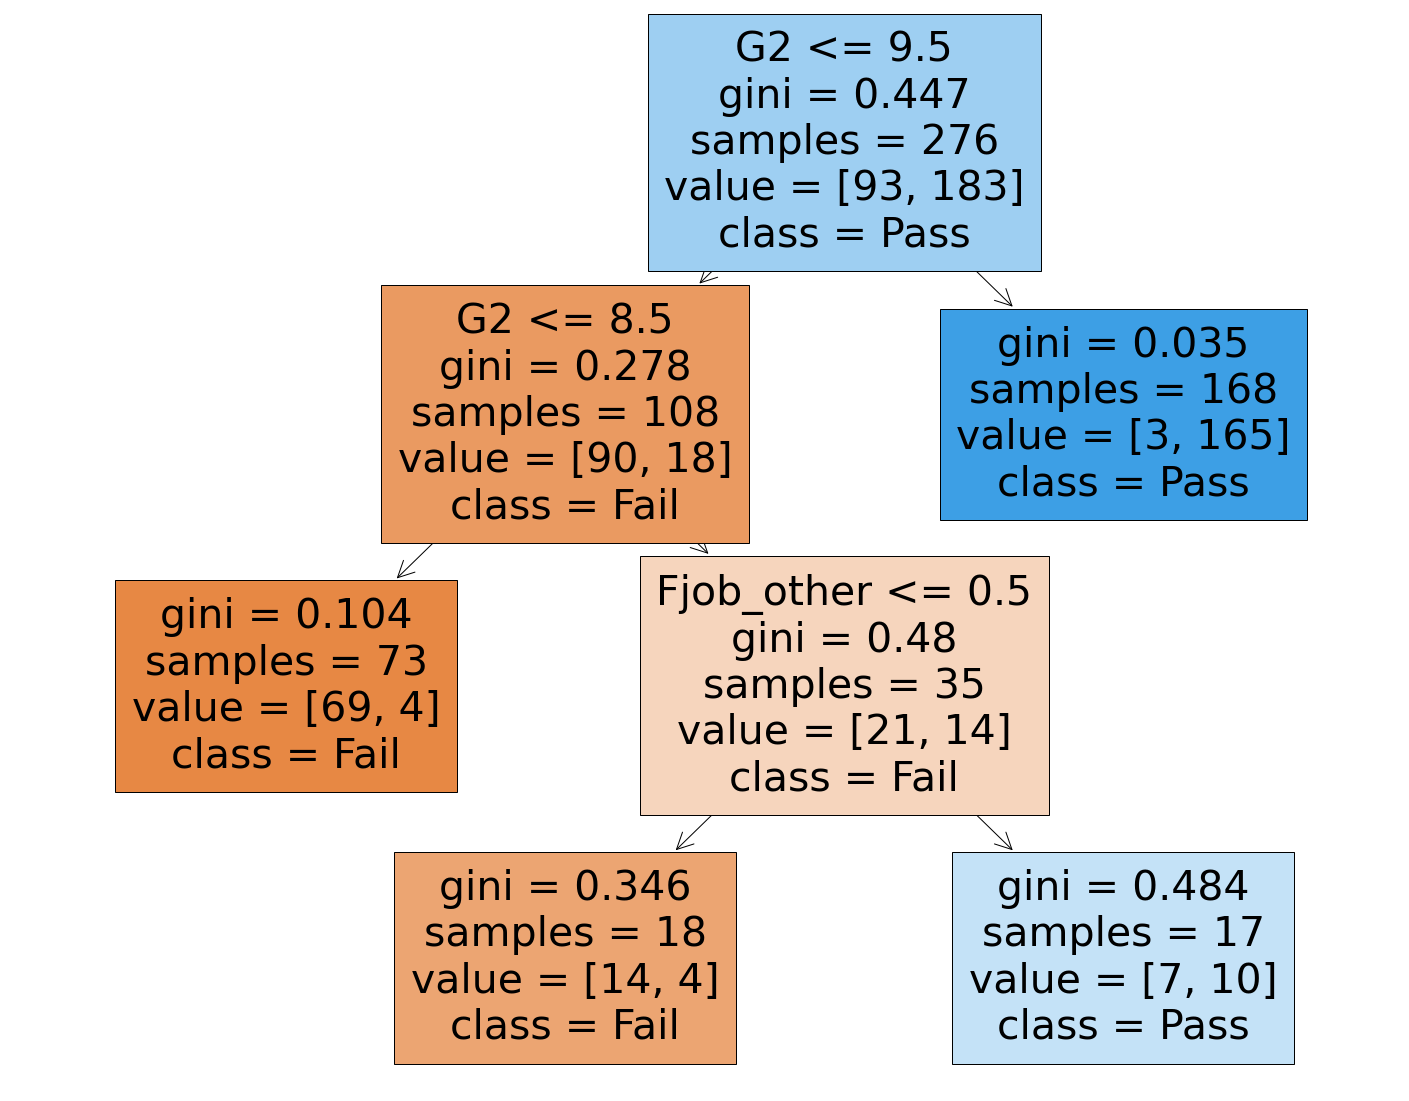

In [14]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_p, 
                   feature_names=all_x.columns,  
                   class_names=['Fail','Pass'],
                   filled=True)

## Random Forest
Bagging: 每次從training set取出K個樣本訓練，取出的樣本會在放回母體中，因此多次訓練中可能有部分資料重複。
Boosting: 將舊分類器的錯誤資料權重提高，加重對錯誤資料的訓練，進而訓練出新的分類器。

# KNN 
## Show the prediction and reasoning of one arbitrary sample in the testing set.

In [140]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(X_test.values.tolist())
distance, num =neigh.kneighbors([X_test.values[0].tolist()])

print('predict: ',knn_y_predict_binary_p[0])
print('true   : ',y_test_binary[0])
print('nearest 5 data  of one arbitrary sample')
print('+'+'-'*11+('+'+'-'*9)*5+'+')
print('|{:<10} |{:8.3f} |{:8.3f} |{:8.3f} |{:8.3f} |{:8.3f} |'.format('data',num[0][1],num[0][2],num[0][3],num[0][4],num[0][5]))
print('+'+'-'*11+('+'+'-'*9)*5+'+')
print('|{:<10} |{:8.3f} |{:8.3f} |{:8.3f} |{:8.3f} |{:8.3f} |'.format('distance',distance[0][1],distance[0][2],distance[0][3],distance[0][4],distance[0][5]))
print('+'+'-'*11+('+'+'-'*9)*5+'+')
print('|{:<10} |{:>8} |{:>8} |{:>8} |{:>8} |{:>8} |'.format('label',knn_y_predict_binary_p[num[0][1]],
                                                                      knn_y_predict_binary_p[num[0][2]],
                                                                      knn_y_predict_binary_p[num[0][3]],
                                                                      knn_y_predict_binary_p[num[0][4]],
                                                                      knn_y_predict_binary_p[num[0][5]]))
print('+'+'-'*11+('+'+'-'*9)*5+'+')

predict:  Pass
true   :  Pass
nearest 5 data  of one arbitrary sample
+-----------+---------+---------+---------+---------+---------+
|data       |  48.000 |  64.000 |  87.000 |  62.000 |  43.000 |
+-----------+---------+---------+---------+---------+---------+
|distance   |   4.583 |   5.568 |   5.831 |   5.831 |   6.083 |
+-----------+---------+---------+---------+---------+---------+
|label      |    Pass |    Pass |    Pass |    Pass |    Pass |
+-----------+---------+---------+---------+---------+---------+


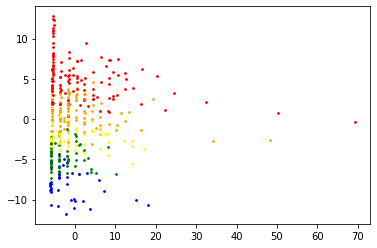

<Figure size 1800x1440 with 0 Axes>

In [151]:
import matplotlib.pyplot as plt 

pca = PCA(n_components=2)
pca_df = pca.fit_transform(all_x)


for i,p in enumerate(pca_df):
    if all_y[i]<10:
        plt.scatter(p[0],p[1],c="red", s = 3)
    elif all_y[i] <12:
        plt.scatter(p[0],p[1],c="orange", s = 3)
    elif all_y[i] <14:
        plt.scatter(p[0],p[1],c="yellow", s = 3)
    elif all_y[i] <16:
        plt.scatter(p[0],p[1],c="green", s = 3)
    else :
        plt.scatter(p[0],p[1],c="blue", s = 3)

plt.figure(figsize=(25,20))
plt.show()